# Time Series Analysis and Forecasting

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import mean_squared_error, accuracy_score
from math import sqrt

In [2]:
energydf = pd.read_csv("energydata.csv")
energydf.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000048,2011-12-08,0.1070,0.159217,0.576,23,0.118021,3.662,0.087
1,MAC000048,2011-12-09,0.0920,0.125750,0.570,48,0.089277,6.036,0.087
2,MAC000048,2011-12-10,0.0925,0.209646,1.322,48,0.288224,10.063,0.087
3,MAC000048,2011-12-11,0.1160,0.245187,2.001,48,0.325140,11.769,0.088
4,MAC000048,2011-12-12,0.0950,0.123188,0.326,48,0.057947,5.913,0.087


In [3]:
weather = pd.read_csv("weather_daily_darksky.csv")
weather.head()

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,...,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,...,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,...,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,...,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25
4,8.22,2011-12-24 23:00:00,252,partly-cloudy-night,2.79,2011-12-24 07:00:00,0.37,4.46,1028.17,2011-12-24 07:00:00,...,7.93,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,Mostly cloudy throughout the day.,2011-12-24 19:00:00,-0.51,2011-12-24 23:00:00,2011-12-24 20:00:00,0.99


In [4]:
energydf = energydf[['day', 'energy_sum']]
energydf.day = pd.to_datetime(energydf.day)
energydf.columns = ['day', 'energy']
energydf = energydf.groupby('day', as_index=False)['energy'].max()    #One row per date
energydf.set_index('day', inplace=True)
energydf.head()

,energy
day,
2011-11-24,5.213
2011-11-25,7.881
2011-11-26,9.592
2011-11-27,9.591
2011-11-28,8.440


In [5]:
energydf.describe()

,energy
count,828.000000
mean,39.927857
std,12.511819
min,2.884000
25%,31.128750
50%,38.394500
75%,48.287000
max,101.041000


In [6]:
energydf.dtypes

energy    float64
dtype: object

In [7]:
weatherdf = weather[['time', 'temperatureHigh']]
weatherdf.time = pd.to_datetime(weatherdf.time).dt.normalize()   #normalize sets the time to midnight
weatherdf.columns = ['day', 'temp']
weatherdf.set_index('day', inplace=True)
weatherdf.head()

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,temp
day,
2011-11-11,10.87
2011-12-11,8.59
2011-12-27,10.33
2011-12-02,7.36
2011-12-24,7.93


In [8]:
weatherdf.describe()

,temp
count,882.000000
mean,13.542392
std,6.260196
min,-0.810000
25%,9.212500
50%,12.470000
75%,17.910000
max,32.400000


Ready to go

## Identify any trends in the datasets and discuss if trends in weather are related to trends in energy consumption.

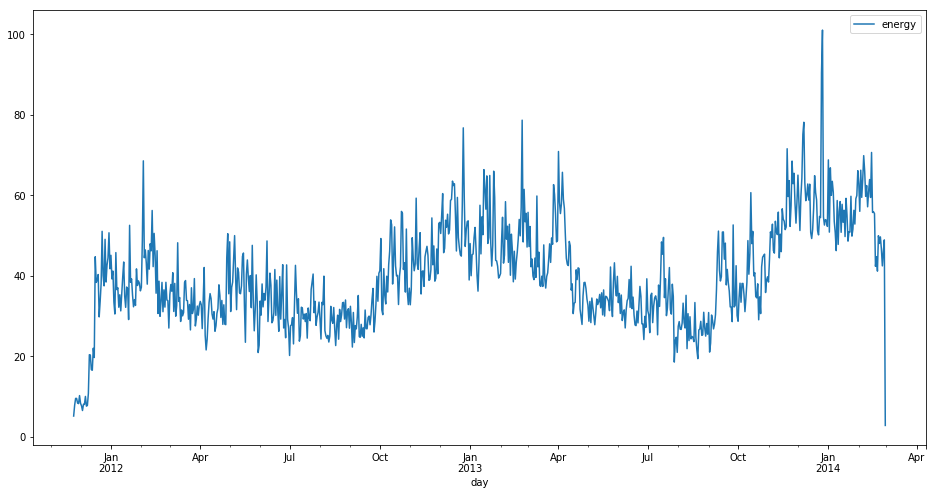

In [9]:
energydf.plot(figsize=(16,8))

It appears that more energy is used in the winter months (October - April), where many people would want to heat their house and workspace. Let's check the weather to see if that makes sense. Also, it appears that energy consumption is increasing, as the level are higher in 2014 than in the 2012. This may be due to increased population, or increased standard of living, or global warming.

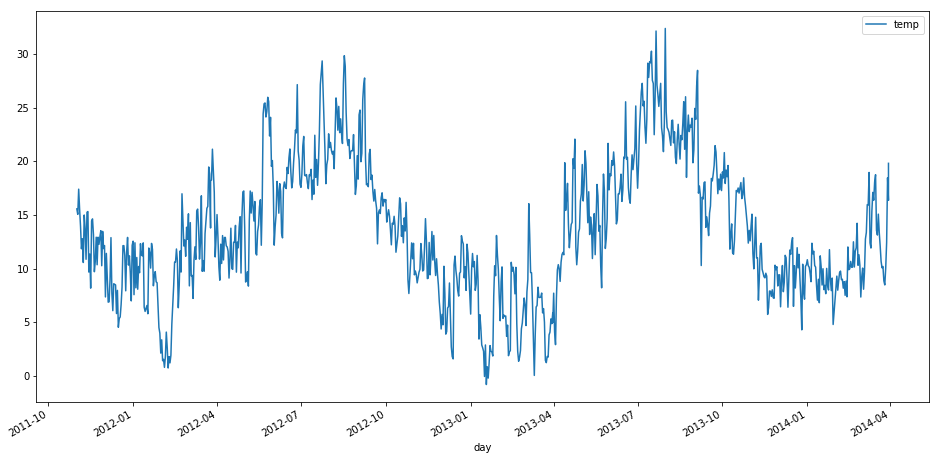

In [10]:
weatherdf.plot(figsize=(16,8))

There's a definite pattern here where the temperature is higher in the summer months than in the winter. In the summer months it reaches a high of about 30 degrees, but from October to April it cools down to almost freezing. Therefore energy consumption goes up in the winter months as more people are heating their houses than people are cooling their houses in the summer. The max temperature in 2013 is higher than in 2012, but two years of data isn't quite enough to declare global warming

## Forecast using simple exponential smoothing the expected temperature for 2014, use the RMS metric to indicate the accuracy of your forecast.

I've realised that exponential smoothing is difficult from forecasting using exponential smoothing, so using the ewm doesn't make sense. We need to split the temp data into testing and training sets to better see the results. The training data will be 2011 - 2013, and the test data will be 2014 data.

In [11]:
train = weatherdf[weatherdf.index.year < 2014]
test = weatherdf[weatherdf.index.year == 2014]

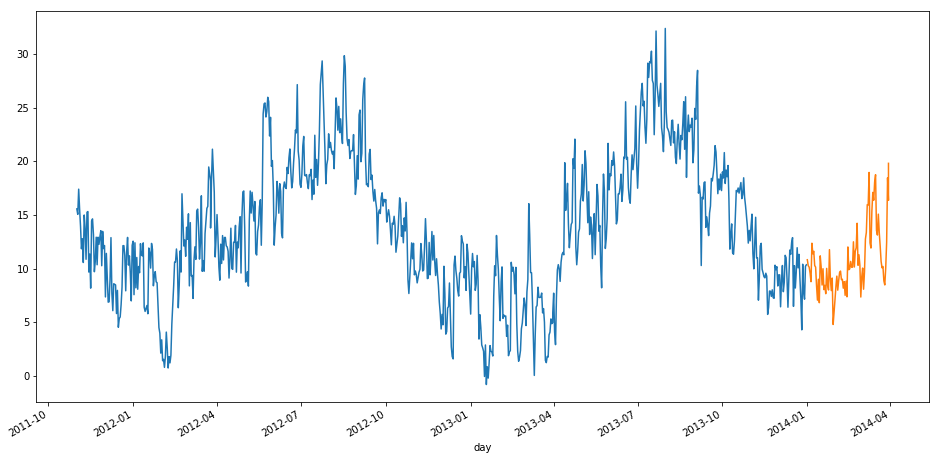

In [12]:
train['temp'].plot(figsize=(16,8))
test['temp'].plot()

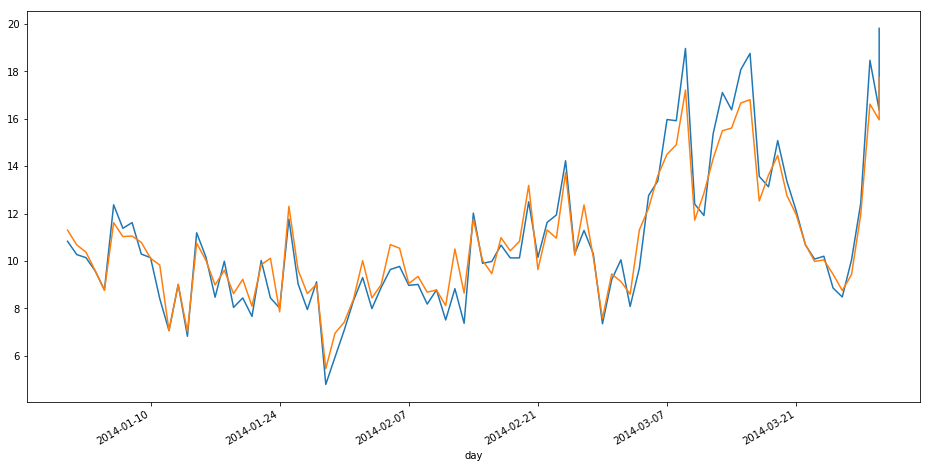

In [13]:
y_hat_avg = test.copy()    
y_hat_avg['SES'] = test.ewm(alpha=0.8).mean()    #Exponentially-weighted moving average gives a weight to more recent values
test['temp'].plot(figsize=(16,8))
y_hat_avg['SES'].plot()

In [14]:
rms = sqrt(mean_squared_error(test.temp, y_hat_avg['SES']))     #Root Mean Squared Error
print(rms)  

0.7873455110514346


The alpha used is 0.8. I don't think I'm doing this correctly. Alpha is the smoothing factor. If the moving average approach is used, then the training dataset is not necessary? The forecasted values only depends on the initial values of the test set, or the last value of the training? When I set alpha to 1, the rms error is 0, but that's to defeat the purpose of forecasting. More research required.

## Forecast using simple exponential smoothing the expected energy consumption for 2014, use the RMS metric to indicate the accuracy of your forecast. 

In [15]:
train = energydf[energydf.index.year < 2014]
test = energydf[energydf.index.year == 2014]

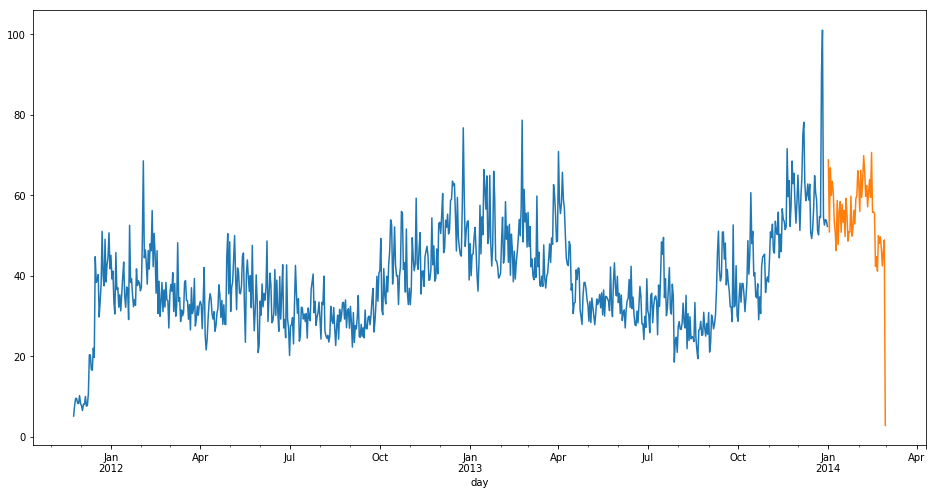

In [16]:
train['energy'].plot(figsize=(16,8))
test['energy'].plot()

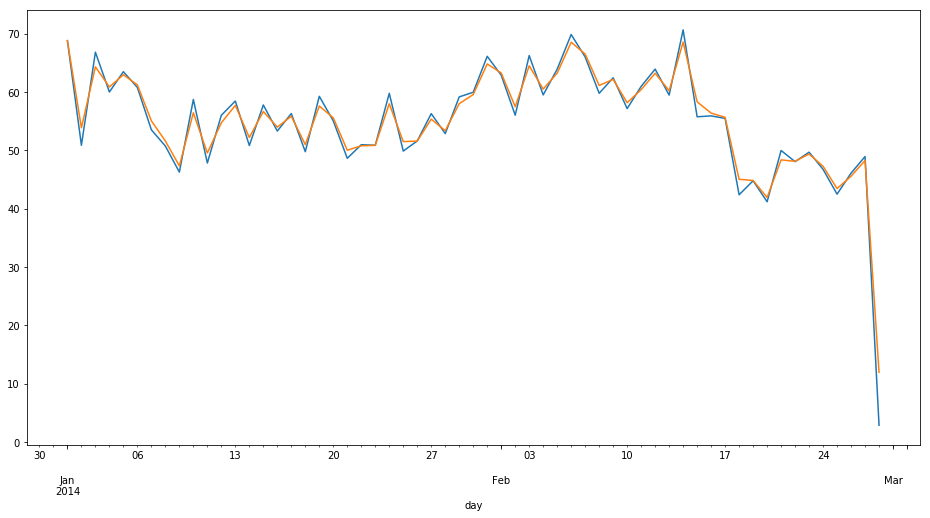

In [17]:
y_hat_avg = test.copy()    
y_hat_avg['SES'] = test.ewm(alpha=0.8).mean()    #Exponentially-weighted moving average gives a weight to more recent values
test['energy'].plot(figsize=(16,8))
y_hat_avg['SES'].plot()

In [18]:
rms = sqrt(mean_squared_error(test.energy, y_hat_avg['SES']))     #Root Mean Squared Error
print(rms)  

1.6990660580777817


The alpha used is 0.8. Same confusion as above

## Combine the initial datasets using an appropriate column as the index.

The date column will be used as the index because it is the common field and is made up of unique values (Dates). Merge, join, or concat can be used here

In [19]:
df = pd.merge(weatherdf, energydf, left_index=True, right_index=True)
df.head()

,temp,energy
day,,
2011-11-24,12.93,5.213
2011-11-25,12.27,7.881
2011-11-26,12.96,9.592
2011-11-27,13.54,9.591
2011-11-28,10.27,8.440


In [20]:
df.describe()

,temp,energy
count,828.000000,828.000000
mean,13.562295,39.908290
std,6.414467,12.510941
min,-0.810000,2.884000
25%,9.092500,31.128750
50%,12.425000,38.382000
75%,18.082500,48.287000
max,32.400000,101.041000


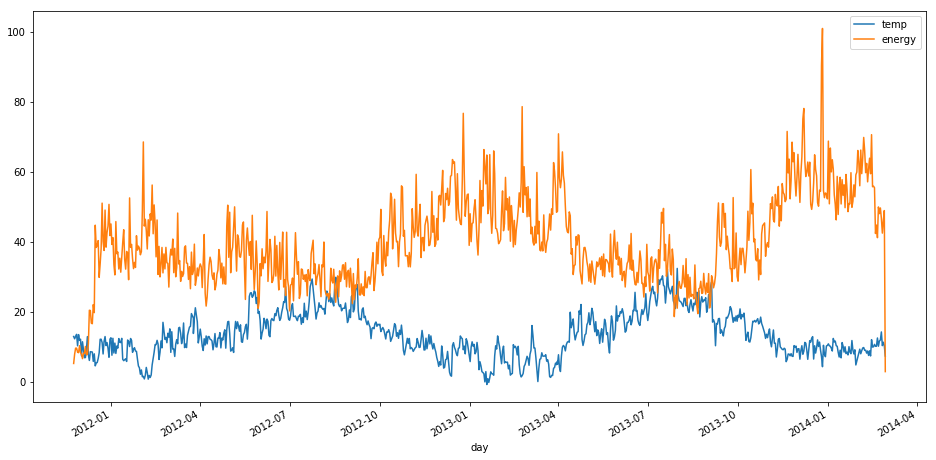

In [21]:
df.plot(figsize=(16,8))

Note that I found to why the combined dataset was dropping the winter months for one of the datasets. Its because in those months, the weather data was taken at 23:00 hrs and not at 0:00 hrs. Therefore, I need to drop the time and only consider the day. This should be done from the start

## Plot separate graphs showing the "temperatureHigh" and "energy_sum" data from the combined dataset.

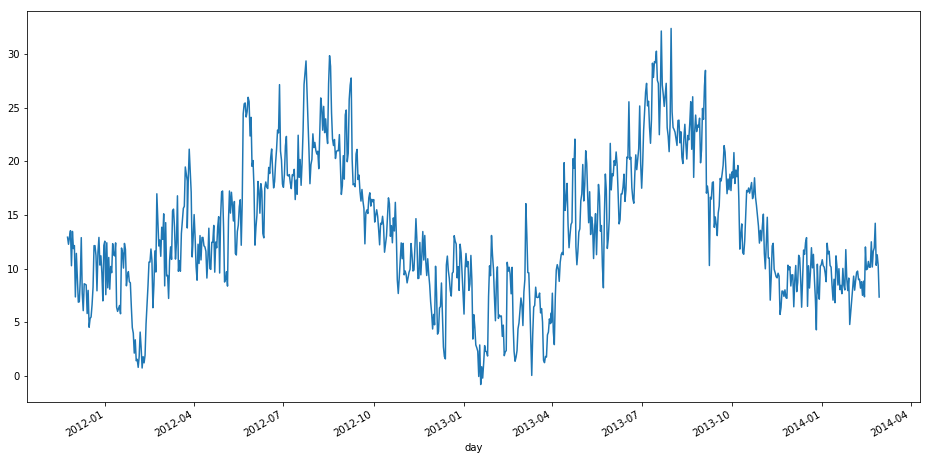

In [22]:
df['temp'].plot(figsize=(16,8))

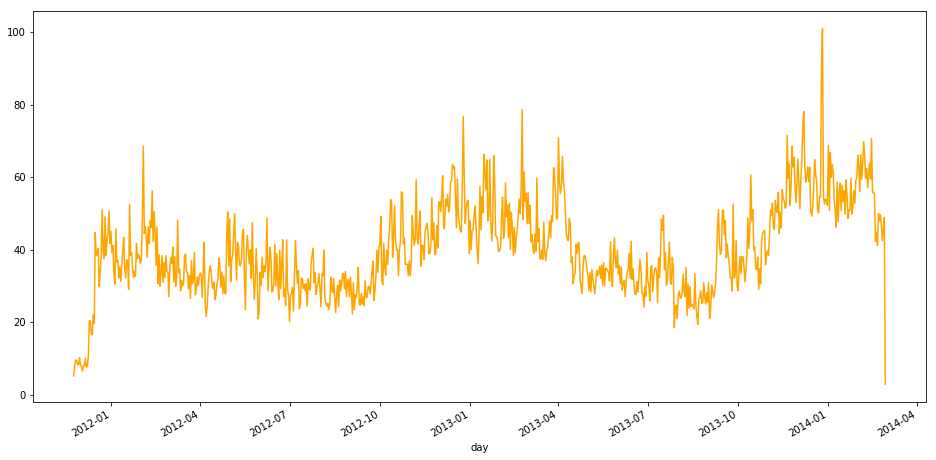

In [23]:
df['energy'].plot(figsize=(16,8), color='orange')

Well its much easier to compare them when they are on the same plot. The same observations that were made previously can be derived from the three plots. However on the combined plot, it is much easier to see the relationship where more energy is used in the colder months, and less in the warmer. In the individual plots it is a little easier to see the long term trends of increasing

# Prediction

## Create a new column in the dataset, derived from the "energy_sum" values, which indicates if energy consumption was high or low

In [24]:
df['high_sump'] = np.where(df['energy'] > 60, 1, 0)
df.head()

,temp,energy,high_sump
day,,,
2011-11-24,12.93,5.213,0
2011-11-25,12.27,7.881,0
2011-11-26,12.96,9.592,0
2011-11-27,13.54,9.591,0
2011-11-28,10.27,8.440,0


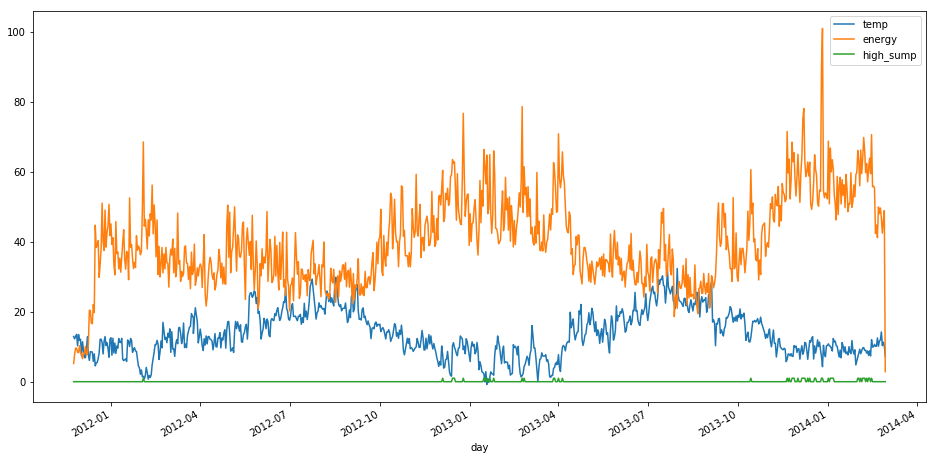

In [25]:
df.plot(figsize=(16,8))

The threshold value was chosen as 60 because 'high' energy consumption suggests that the demand is more than the average. 60 accounts of the large energy spikes, but excludes the 'rises' in the graph which seem to be in a pattern

## Split the dataset into a train and test set.

Well first we need to more columns, so we can go back to the original set and grab from there. 

In [26]:
extra = weather[['time', 'temperatureLow', 'apparentTemperatureMin', 'apparentTemperatureMin', 'cloudCover', 'windSpeed', 'temperatureMin']]
extra.time = pd.to_datetime(extra.time).dt.normalize()   #normalize sets the time to midnight
extra.set_index('time', inplace=True)
extra.head()

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,temperatureLow,apparentTemperatureMin,apparentTemperatureMin,cloudCover,windSpeed,temperatureMin
time,,,,,,
2011-11-11,10.87,6.48,6.48,0.79,3.88,8.85
2011-12-11,3.09,0.11,0.11,0.56,3.94,2.48
2011-12-27,8.03,5.59,5.59,0.85,3.54,8.03
2011-12-02,6.33,0.46,0.46,0.32,3.00,2.56
2011-12-24,7.45,-0.51,-0.51,0.37,4.46,3.17


These columns were chosen since cooler temperatures seem to increase energy consumption. London people don't usually have to worry about hot days.

In [27]:
df = pd.merge(df, extra, left_index=True, right_index=True)
df.head()

,temp,energy,high_sump,temperatureLow,apparentTemperatureMin,apparentTemperatureMin,cloudCover,windSpeed,temperatureMin
2011-11-24,12.93,5.213,0,9.71,7.01,7.01,0.41,4.04,8.56
2011-11-25,12.27,7.881,0,7.01,4.84,4.84,0.48,5.02,7.46
2011-11-26,12.96,9.592,0,11.59,4.69,4.69,0.44,5.75,7.01
2011-11-27,13.54,9.591,0,1.31,2.94,2.94,0.42,5.48,4.47
2011-11-28,10.27,8.440,0,10.27,1.31,1.31,0.56,2.34,1.31


In [28]:
any_nan = df.columns[df.isnull().any()]
len(list(any_nan))

1

In [29]:
df.dropna(axis=0, inplace=True)
df.head()

,temp,energy,high_sump,temperatureLow,apparentTemperatureMin,apparentTemperatureMin,cloudCover,windSpeed,temperatureMin
2011-11-24,12.93,5.213,0,9.71,7.01,7.01,0.41,4.04,8.56
2011-11-25,12.27,7.881,0,7.01,4.84,4.84,0.48,5.02,7.46
2011-11-26,12.96,9.592,0,11.59,4.69,4.69,0.44,5.75,7.01
2011-11-27,13.54,9.591,0,1.31,2.94,2.94,0.42,5.48,4.47
2011-11-28,10.27,8.440,0,10.27,1.31,1.31,0.56,2.34,1.31


In [30]:
train = df[df.index.year < 2014]
test = df[df.index.year == 2014]

In [31]:
x_train = train.drop(['high_sump', 'energy'], axis=1)
y_train = train["high_sump"]
x_test = test.drop(["high_sump", 'energy'], axis=1)
y_test = test["high_sump"]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((773, 7), (773,), (58, 7), (58,))

## Use an appropriate classifier to predict the energy consumption for 2014

Let's try the KNN classifier

In [32]:
knn = KNeighborsClassifier() 
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
acc_knn = round(accuracy_score(y_test,y_pred) * 100, 2)
acc_knn

75.86

Not the most accurate. May be because energy consumption is not solely based on the weather

In [33]:
random_forest = RandomForestClassifier()
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_test)
acc_random_forest = round(accuracy_score(y_test,y_pred) * 100, 2)
acc_random_forest

75.86

well that's strange